In [69]:
import numpy as np
import torch
from torch.utils.dlpack import to_dlpack
import cupy as cu
from cupyx import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [5]:
%matplotlib inline

In [6]:
import matplotlib as mpl
# mpl.rc('image', cmap='gray')
mpl.rc('figure', figsize = (32,16))

In [7]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

cu.cuda.Device(1).use()
device

'cuda:1'

In [116]:
import pandas as pd
import numpy as np
import os

DATA_DIR = "data"
salt = 'hackathon-three-cities_'
l1_nrows = 1512
l2_nrows = 1248
n_horizons = 4
y_height = 3001

# Загружаем значения высот в узлах сетки для срезов L1 и L2

all_data_l1 = np.load(os.path.join(DATA_DIR, salt+"all_data_L1.npy"))
all_data_l2 = np.load(os.path.join(DATA_DIR, salt+"all_data_L2.npy"))

assert all_data_l1.shape == (l1_nrows, y_height), "Неправильный размер all_data_L1.npy"
assert all_data_l2.shape == (l2_nrows, y_height), "Неправильный размер all_data_L2.npy"

# Загружаем горизонты

l1_horizons_train = pd.read_csv(os.path.join(DATA_DIR, salt+"L1_horizons_train.csv"))
l2_horizons_train = pd.read_csv(os.path.join(DATA_DIR, salt+"L2_horizons_train.csv"))

assert l1_horizons_train.shape == (l1_nrows, n_horizons+1)
assert l2_horizons_train.shape == (l2_nrows, n_horizons+1)

sample_submission = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))
my_submission = sample_submission.copy()

In [485]:
start_point = [521, 813]

In [525]:
var = 80
y_min = start_point[1]-var
y_max = start_point[1]+var
data = all_data_l1.T[600:1000]
data = data - data.min()
data = data / data.max()
data *= 300

In [532]:
start_point = [521, 813-600]

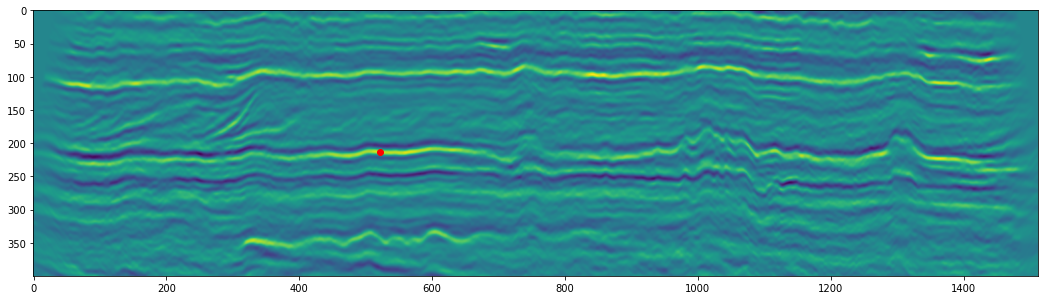

In [533]:
plt.imshow(data)
plt.scatter([start_point[0]],[start_point[1]], color='red')

In [528]:
arr = torch.tensor(data, device=device, dtype=torch.float32)
W = data.shape[1]
H = data.shape[0]
N = W * H

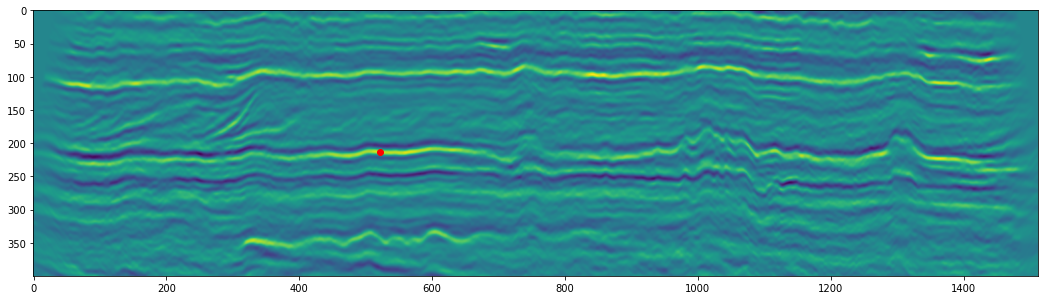

In [534]:
plt.imshow(arr.cpu().numpy())
plt.scatter([start_point[0]],[start_point[1]], color='red')

In [535]:
cust_filter = torch.tensor([[[0, 1, 0], [0, -1, 0], [0, 0, 0]], 
                            [[0, 0, 0], [0, -1, 1], [0, 0, 0]],
                            [[0, 0, 0], [0, -1, 0], [0, 1, 0]],
                            [[0, 0, 0], [1, -1, 0], [0, 0, 0]]], device=device, dtype=torch.float32)

In [536]:
cust_filter, cust_filter.shape

(tensor([[[ 0.,  1.,  0.],
          [ 0., -1.,  0.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0., -1.,  1.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0., -1.,  0.],
          [ 0.,  1.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 1., -1.,  0.],
          [ 0.,  0.,  0.]]], device='cuda:1'),
 torch.Size([4, 3, 3]))

In [537]:
vectors = torch.nn.functional.conv2d(input=arr[None, None, ...], weight=cust_filter[:, None], padding=1)
vectors = vectors[0]
vectors[0, 0, :] = 0
vectors[1, :, -1] = 0
vectors[2, -1, :] = 0
vectors[3, :, 0] = 0
vectors, vectors.shape

(tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [-0.7168, -0.8355, -0.9904,  ...,  1.6577,  1.3089,  1.1016],
          [-1.3702, -1.4474, -1.6325,  ...,  1.6750,  1.3531,  1.3455],
          [-2.0770, -2.2362, -2.3698,  ...,  1.3823,  1.3836,  1.5269]],
 
         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [-0.3839, -0.4714, -0.8227,  ...,  0.7266,  0.7256,  0.0000],
          [-0.3067, -0.2863, -0.2587,  ...,  1.0484,  0.7332,  0.0000],
          [-0.1475, -0.1527,  0.1022,  ...,  1.0471,  0.5899,  0.0000]],
 
         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,

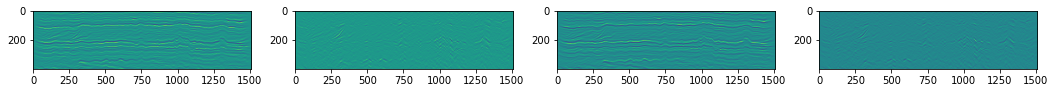

In [538]:
plt.rcParams['figure.figsize'] = [18, 12]
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(vectors[i].cpu().numpy())

In [539]:
square = torch.ones_like(vectors)
square[:-1] += vectors[:-1] ** 2 + vectors[1:] ** 2
square[-1] +=  vectors[0] ** 2 + vectors[-1] ** 2
square = torch.sqrt(square) / 2

In [540]:
square, square.shape

(tensor([[[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          ...,
          [0.6444, 0.6929, 0.8151,  ..., 1.0339, 0.9000, 0.7439],
          [0.8619, 0.8912, 0.9659,  ..., 1.1073, 0.9177, 0.8382],
          [1.1549, 1.2272, 1.2871,  ..., 1.0009, 0.9031, 0.9126]],
 
         [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          ...,
          [0.8696, 0.9106, 1.0419,  ..., 1.0409, 0.9162, 0.8382],
          [1.1627, 1.2332, 1.2926,  ..., 1.0012, 0.9290, 0.9126],
          [0.5054, 0.5058, 0.5026,  ..., 0.7240, 0.5805, 0.5000]],
 
         [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ...,

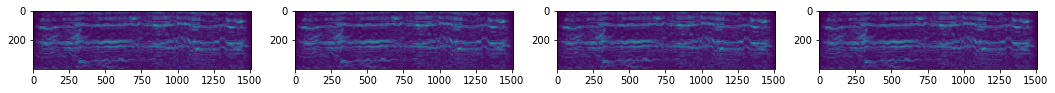

In [541]:
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(square[i].cpu().numpy())

In [542]:
square[0, 0, :] = 0
square[1, :, -1] = 0
square[2, -1, :] = 0
square[3, :, 0] = 0

In [543]:
vertex_area = square.sum(axis=0)

In [544]:
vertex_area, vertex_area.shape

(tensor([[1.0000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.0000],
         [1.5000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 1.5000],
         [1.5000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 1.5000],
         ...,
         [2.3622, 3.1831, 3.5849,  ..., 4.2163, 3.6327, 2.4849],
         [3.1772, 4.2516, 4.5204,  ..., 4.3353, 3.8396, 2.7366],
         [1.6603, 2.9600, 3.0781,  ..., 2.8462, 2.4850, 1.8717]],
        device='cuda:1'),
 torch.Size([400, 1512]))

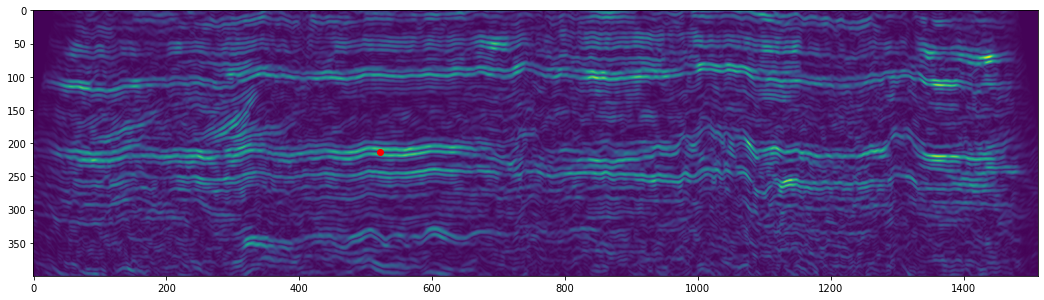

In [545]:
plt.imshow(vertex_area.cpu().numpy())
plt.scatter([start_point[0]],[start_point[1]], color='red')

In [547]:
np.save('vertex_area.npy',vertex_area.cpu().numpy())

In [502]:
del square, arr
torch.cuda.empty_cache()

In [503]:
cotangens = torch.zeros_like(vectors)
cotangens[0] = 1 / torch.tan(torch.acos((1 + vectors[3] ** 2 - vectors[3] * vectors[0]) / (torch.sqrt(2 + (vectors[0] - vectors[3]) ** 2) * torch.sqrt(1 + vectors[3] ** 2))))
cotangens[0] += 1 / torch.tan(torch.acos((1 + vectors[1] ** 2 - vectors[1] * vectors[0]) / (torch.sqrt(2 + (vectors[0] - vectors[1]) ** 2) * torch.sqrt(1 + vectors[1] ** 2))))

cotangens[1] = 1 / torch.tan(torch.acos((1 + vectors[0] ** 2 - vectors[0] * vectors[1]) / (torch.sqrt(2 + (vectors[1] - vectors[0]) ** 2) * torch.sqrt(1 + vectors[0] ** 2))))
cotangens[1] += 1 / torch.tan(torch.acos((1 + vectors[2] ** 2 - vectors[2] * vectors[1]) / (torch.sqrt(2 + (vectors[1] - vectors[2]) ** 2) * torch.sqrt(1 + vectors[2] ** 2))))

cotangens[2] = 1 / torch.tan(torch.acos((1 + vectors[3] ** 2 - vectors[3] * vectors[2]) / (torch.sqrt(2 + (vectors[2] - vectors[3]) ** 2) * torch.sqrt(1 + vectors[3] ** 2))))
cotangens[2] += 1 / torch.tan(torch.acos((1 + vectors[1] ** 2 - vectors[1] * vectors[2]) / (torch.sqrt(2 + (vectors[2] - vectors[1]) ** 2) * torch.sqrt(1 + vectors[1] ** 2))))

cotangens[3] = 1 / torch.tan(torch.acos((1 + vectors[0] ** 2 - vectors[0] * vectors[3]) / (torch.sqrt(2 + (vectors[3] - vectors[0]) ** 2) * torch.sqrt(1 + vectors[0] ** 2))))
cotangens[3] += 1 / torch.tan(torch.acos((1 + vectors[2] ** 2 - vectors[2] * vectors[3]) / (torch.sqrt(2 + (vectors[3] - vectors[2]) ** 2) * torch.sqrt(1 + vectors[2] ** 2))))

cotangens[0, 0, :] = 0
cotangens[1, :, -1] = 0
cotangens[2, -1, :] = 0
cotangens[3, :, 0] = 0

In [504]:
main_i = torch.arange(end=N, device=device)
upper_edge_i = torch.arange(start=W, end=N, device=device)
right_edge_i = main_i[cotangens[1].view(-1) != 0]
left_edge_i = main_i[cotangens[3].view(-1) != 0]
down_edge_i = torch.arange(start=0, end=N-W, device=device)

In [505]:
main_v = cotangens.sum(axis=0).view(-1)
upper_edge_v = cotangens[0].view(-1)[upper_edge_i]
right_edge_v = cotangens[1].view(-1)[right_edge_i]
down_edge_v = cotangens[2].view(-1)[down_edge_i]
left_edge_v = cotangens[3].view(-1)[left_edge_i]

In [506]:
# cu.cuda.Device(0).use()

main_v = cu.fromDlpack(to_dlpack(main_v))
main_i = cu.fromDlpack(to_dlpack(main_i))

upper_edge_v = cu.fromDlpack(to_dlpack(upper_edge_v))
upper_edge_i = cu.fromDlpack(to_dlpack(upper_edge_i))

right_edge_v = cu.fromDlpack(to_dlpack(right_edge_v))
right_edge_i = cu.fromDlpack(to_dlpack(right_edge_i))

down_edge_v = cu.fromDlpack(to_dlpack(down_edge_v))
down_edge_i = cu.fromDlpack(to_dlpack(down_edge_i))


left_edge_v = cu.fromDlpack(to_dlpack(left_edge_v))
left_edge_i = cu.fromDlpack(to_dlpack(left_edge_i))

In [507]:
upper_m = scipy.sparse.coo_matrix((upper_edge_v / 2, (upper_edge_i, main_i[:-W])), shape=(N, N))
right_m = scipy.sparse.coo_matrix((right_edge_v / 2, (right_edge_i, right_edge_i + 1)), shape=(N, N))
down_m = scipy.sparse.coo_matrix((down_edge_v / 2, (down_edge_i, main_i[W:])), shape=(N, N))
left_m = scipy.sparse.coo_matrix((left_edge_v / 2, (left_edge_i, left_edge_i - 1)), shape=(N, N))
main_m = scipy.sparse.diags(-main_v / 2)

In [508]:
L = main_m + upper_m + right_m + down_m + left_m

In [509]:
M = scipy.sparse.diags(cu.fromDlpack(to_dlpack(vertex_area.view(-1) / 3)))

In [510]:
M.dtype, L.dtype

(dtype('float32'), dtype('float32'))

In [511]:
del main_m, upper_m, right_m, down_m, left_m
del vertex_area
del main_v, main_i, upper_edge_v, upper_edge_i, right_edge_v, right_edge_i, down_edge_v, down_edge_i, left_edge_v, left_edge_i
torch.cuda.empty_cache()

In [512]:
b = cu.zeros(N, dtype=cu.float32)
b[start_point[1] * W + start_point[0]] = 1
# b[3*W+20] = 1
b.dtype

dtype('float32')

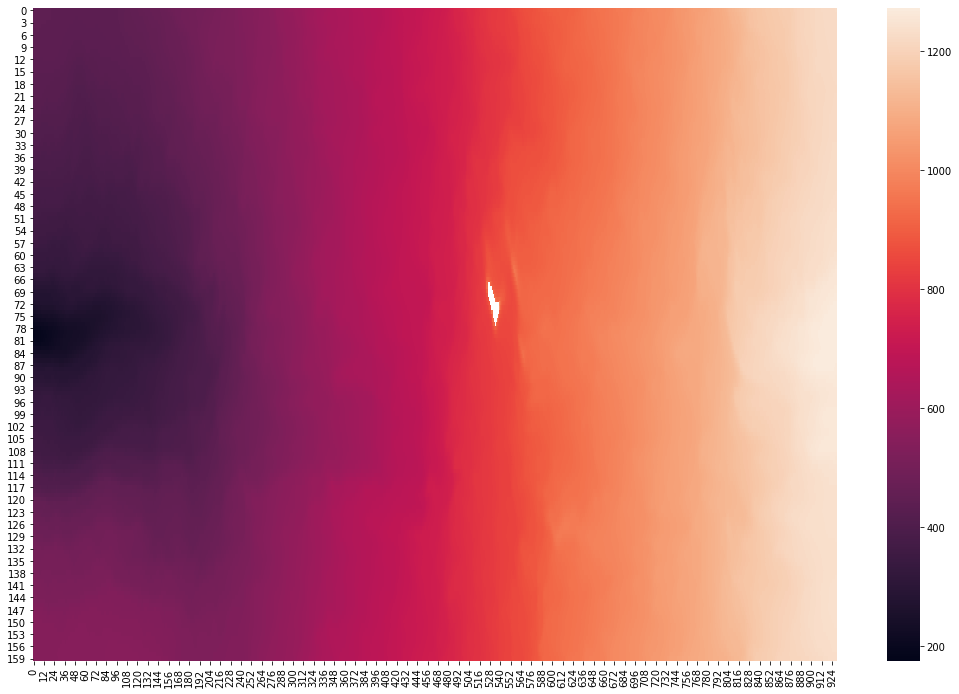

7.2246785163879395


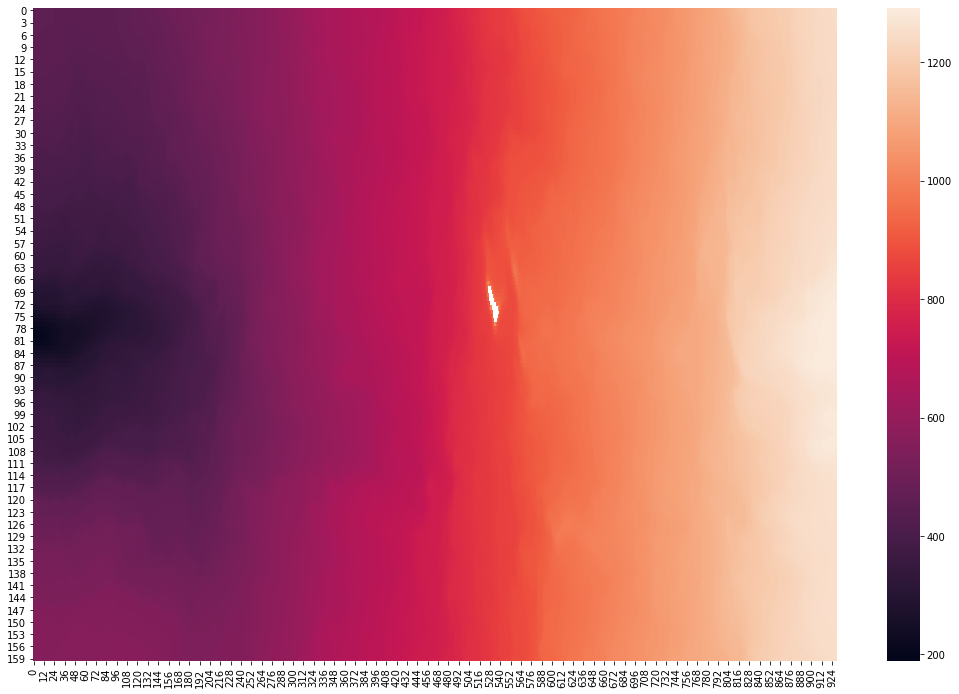

7.262112140655518


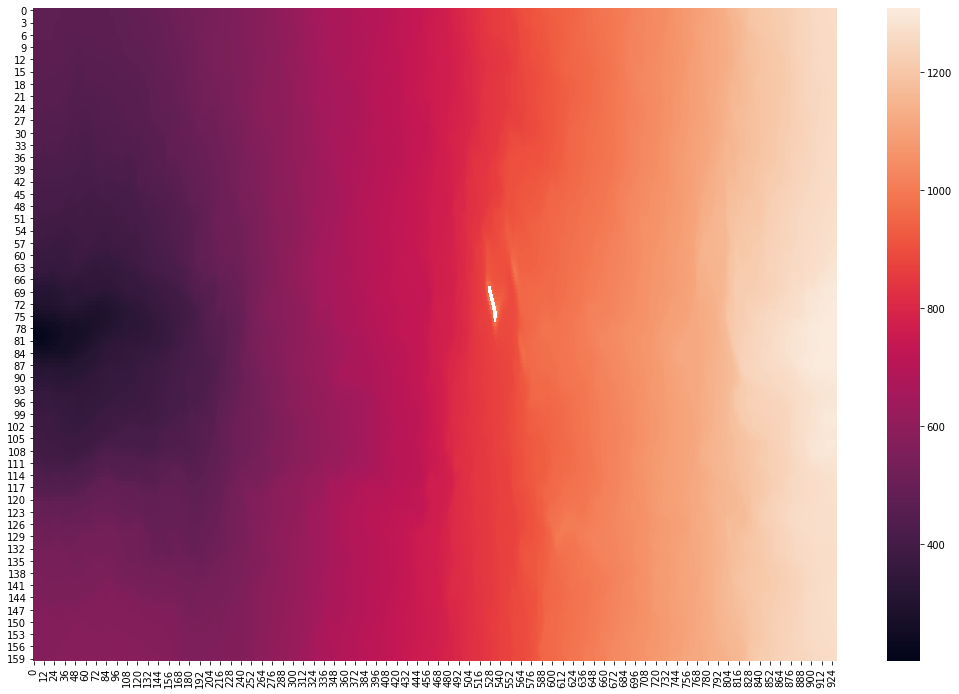

7.203045606613159


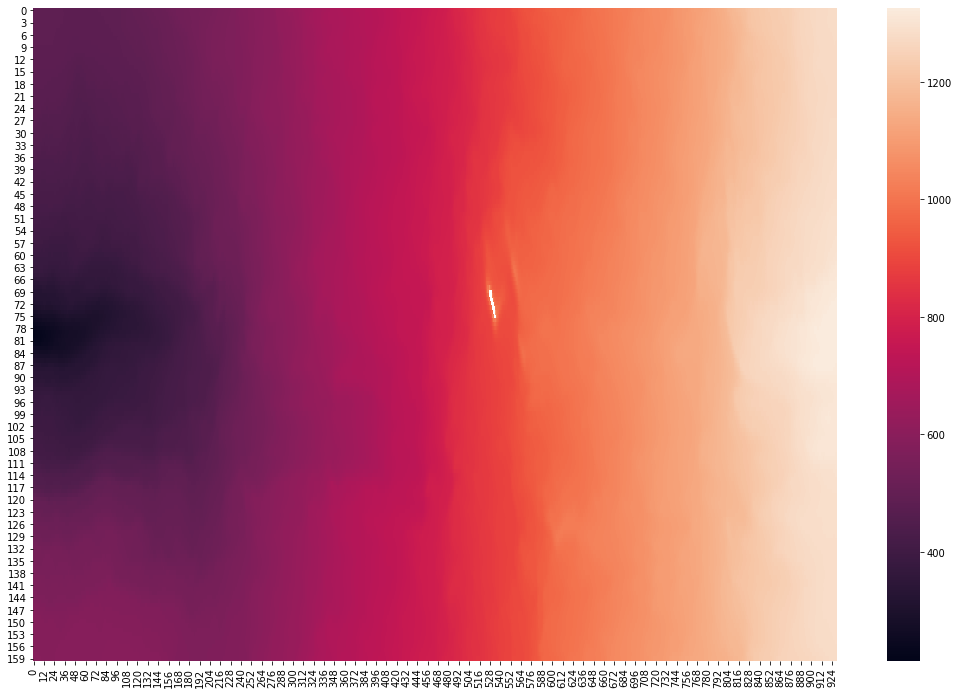

7.1117470264434814


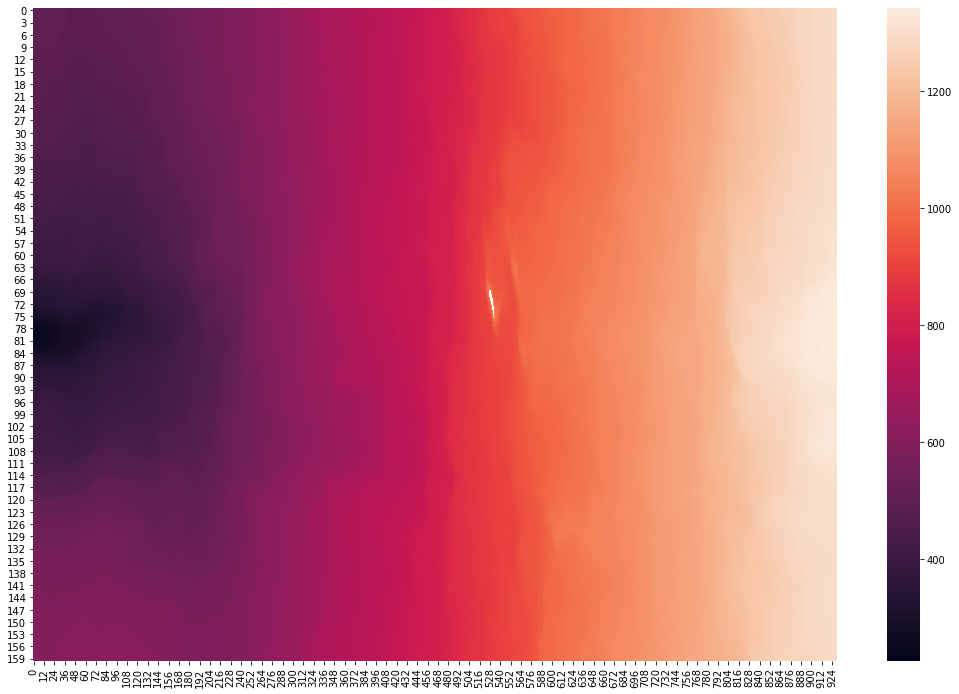

7.1585001945495605


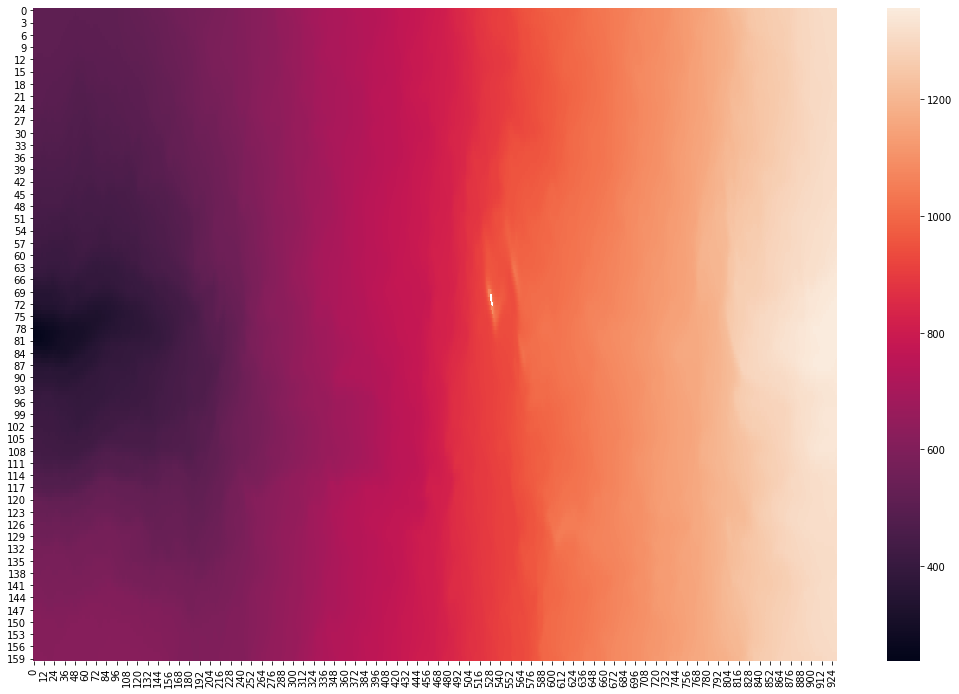

7.2091965675354


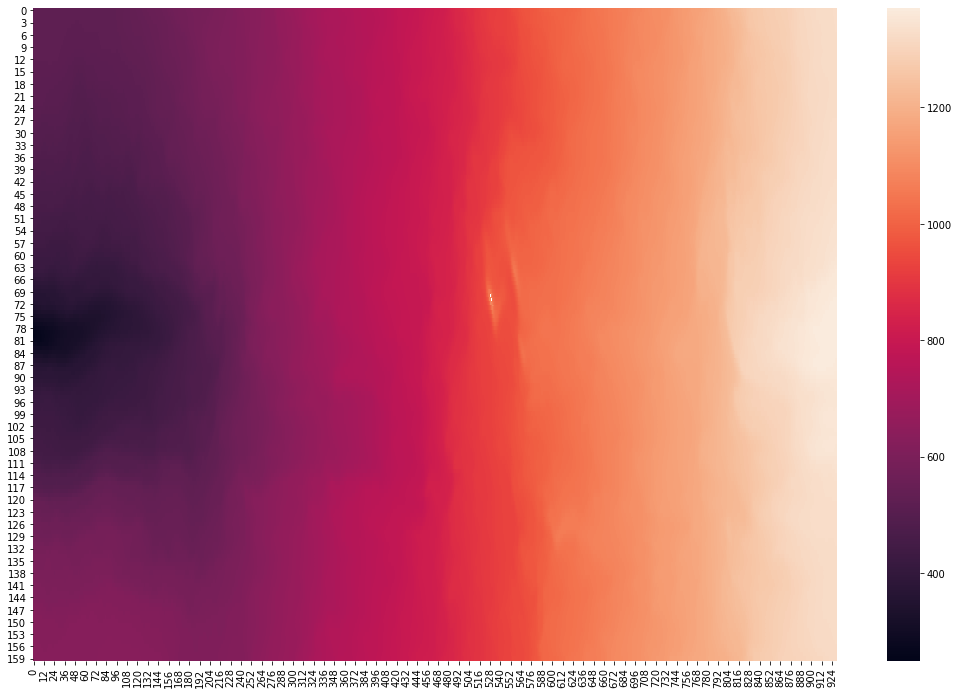

7.174670934677124


In [513]:
for i in range(800, 1500, 100):
    start = time.time()
    T = i
    u = scipy.sparse.linalg.lsqr(M - T * L, b)
    u = u[0]
    sns.heatmap(cu.asnumpy((-T ** 0.5 * cu.log(u)).reshape(H, W)))
    plt.show()
    end = time.time()
    print(end - start)

6.252122402191162

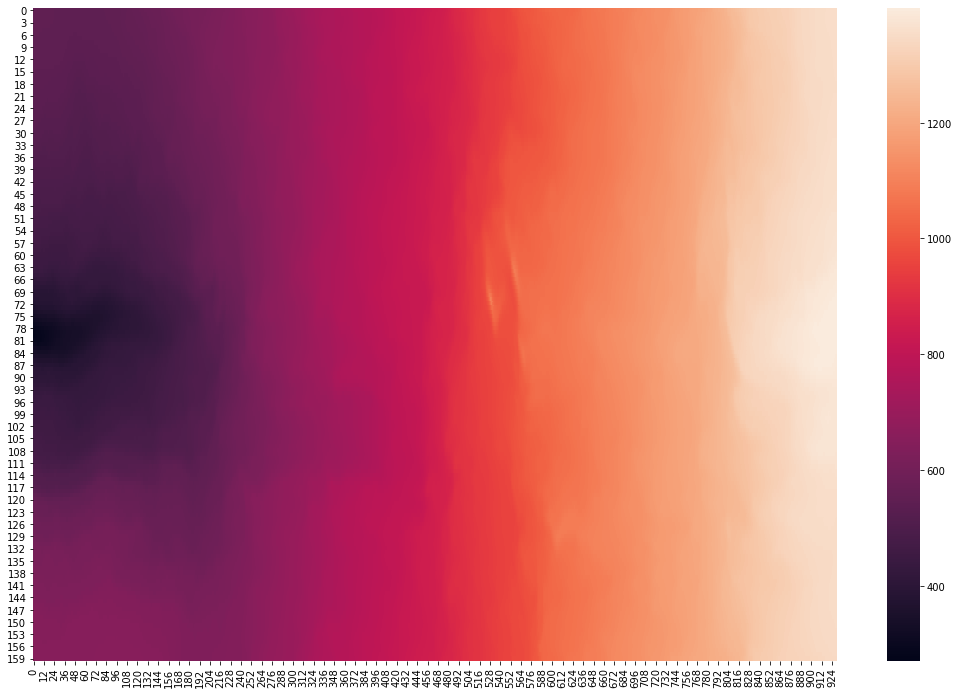

In [514]:
start = time.time()
T = 1600
u = scipy.sparse.linalg.lsqr(M - T * L, b)
u = u[0]
sns.heatmap(cu.asnumpy((-T ** 0.5 * cu.log(u)).reshape(H, W)))
end = time.time()
end - start

In [515]:
s = cu.asnumpy((-T ** 0.5 * cu.log(u)).reshape(H, W))

In [479]:
df = pd.read_csv('my_submission_evrstc21.csv')

In [373]:
tmp = df.y.values
tmp.shape

(930,)

In [375]:
 np.convolve((df.y).astype(float), np.ones((5,))/5,mode='valid').shape

(926,)

In [376]:
tmp[2:-2] = np.convolve((df.y).astype(float), np.ones((5,))/5,mode='valid')
df.y = tmp

In [378]:
df.to_csv('evrstc21_smoothed.csv', index=0)

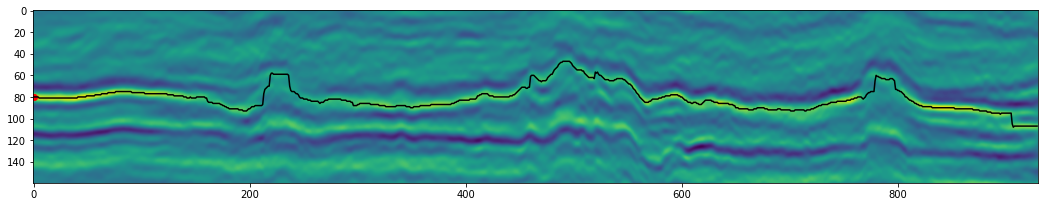

In [481]:
plt.imshow(data)
plt.scatter([start_point[0]],[start_point[1]], color='red')
plt.plot(df.y-y_min, color='black')

In [516]:
end_point = [s.shape[1]-1, np.argmin(s[:, -1])]

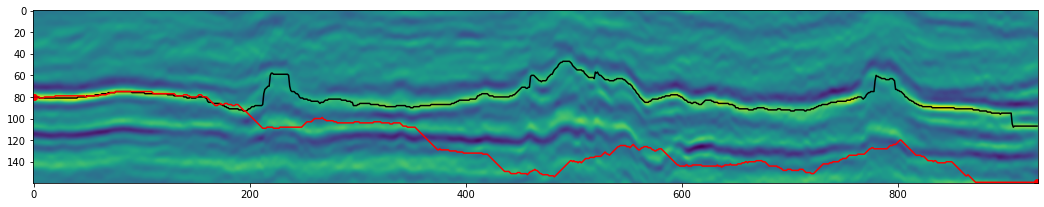

In [524]:
plt.imshow(s)
plt.imshow(data)
plt.scatter([start_point[0]],[start_point[1]], color='red')
plt.scatter([end_point[0]],[end_point[1]], color='red' )
plt.plot(df.y-y_min, color='black')

plt.plot(y_hat, color='red')

In [361]:
np.convolve(df.y-y_min, [1,1,1],mode='same').shape

(930,)

In [518]:
y_hat = [end_point[1]]

In [519]:
i,j = end_point[1],end_point[0]

In [520]:
while j!= 0:
    neighbours = np.array([s[i-1,j-1],
                            s[i,j-1],
                           s[i+(1 if i+1 < s.shape[0] else 0),j-1]])

                          
    upd = np.argmin(neighbours)
    i += (upd - 1)
    j -= 1
    y_hat.append(i)
    

In [521]:
y_hat=np.array(y_hat)

In [522]:
y_hat = y_hat[::-1]

In [354]:
x = np.arange(s.shape[1]-1, s.shape[1]-1-len(y_hat),-1)

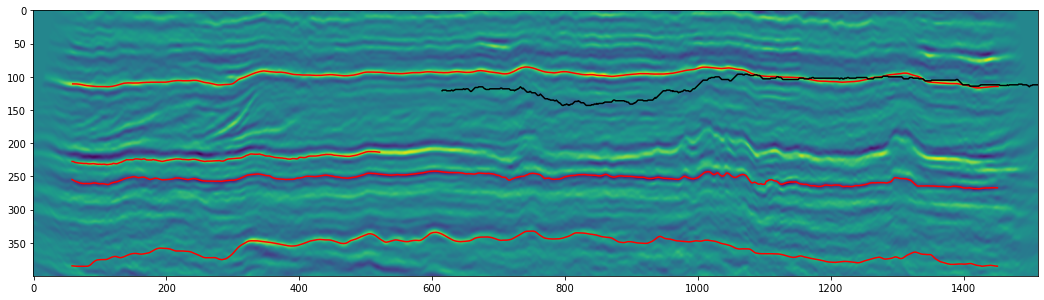

In [184]:
plt.imshow(all_data_l1.T[600:1000])
plt.plot(l1_horizons_train.hor_1-600, color='red')
plt.plot(l1_horizons_train.hor_2-600, color='red')

plt.plot(x+400, y_hat, color='black')


plt.plot(l1_horizons_train.hor_3-600, color='red')
plt.plot(l1_horizons_train.hor_4-600, color='red')

In [177]:
len(y_hat)

897

In [ ]:
plt.plot

In [162]:
len(s[:, -1])

400

In [276]:
my_submission.x.shape

(930,)

In [277]:
y_hat.shape

(930,)

In [278]:
my_submission.y = y_hat+600

In [279]:
my_submission.to_csv('heat_method.csv', index=0)

# u = scipy.sparse.linalg.lsqr(M - L, b)
# u = u[0]
start = time.time()

for i in range(4):
    u = scipy.sparse.linalg.lsqr(M - (0.1 +  TTT * i) * L, b)
    u = u[0]
    plt.subplot(2, 2, 1 + i)
    sns.heatmap(cu.asnumpy((-(0.1 +  TTT * i) ** 0.5 * cu.log(u)).reshape(H, W)))

end = time.time()
end - start
#     del u
#     torch.cuda.empty_cache()

(u == 0).sum(), u.shape[0]

# _ = plt.hist(cu.asnumpy(u.reshape(H, W).clip(0, 0.1)))

vectors = cu.fromDlpack(to_dlpack(vectors))
e1 = cu.zeros(shape=(3, H, W), dtype=cu.float32)
e2 = cu.zeros(shape=(3, H, W,), dtype=cu.float32)

e1[0, :, :] = -1
e1[2, :, :] = vectors[0]
e2[1:, :,] = 1
e2[2:, :,] = vectors[1]
cross_n1 = cu.cross(e1, e2, axis=0)

e1[...] = 0
e2[...] = 0

e1[1, :, :] = 1
e1[2, :, :] = vectors[1]
e2[0:, :,] = 1
e2[2:, :,] = vectors[2]
cross_n2 = cu.cross(e1, e2, axis=0)

e1[...] = 0
e2[...] = 0

e1[0, :, :] = 1
e1[2, :, :] = vectors[2]
e2[1:, :,] = -1
e2[2:, :,] = vectors[3]
cross_n3 = cu.cross(e1, e2, axis=0)

e1[...] = 0
e2[...] = 0

e1[1, :, :] = -1
e1[2, :, :] = vectors[3]
e2[0:, :,] = -1
e2[2:, :,] = vectors[0]
cross_n4 = cu.cross(e1, e2, axis=0)